In [2]:
import pandas as pd
import numpy as np
import datetime as date
import os
import tqdm
import ast
import json
import sqlite3
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
con = sqlite3.connect("../data/database/ICLR.db")

In [4]:
query = '''
SELECT keywords, conf_year,id,title FROM submissions
WHERE
conf_year in (2017,2018)
'''


df_keywords = pd.read_sql_query(query,con)

In [5]:
assert df_keywords[df_keywords['conf_year'] == '2018'].shape[0] == 911
assert df_keywords[df_keywords['conf_year'] == '2017'].shape[0] == 490

In [6]:
counter = 0

for i in df_keywords[df_keywords['conf_year']=='2017'].keywords.tolist():
    if i =='[]':
        counter += 1

print('There are {} submissions without keywords in 2017'.format(counter))

There are 95 submissions without keywords in 2017


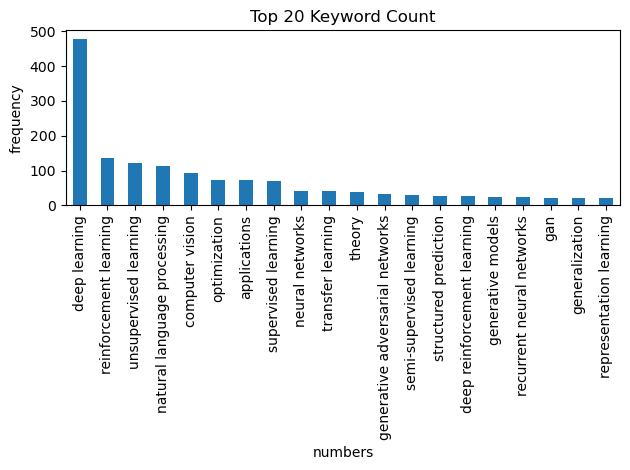

In [7]:
lst_keywords_list = [ast.literal_eval(kw_list) for kw_list in df_keywords.keywords.tolist() if kw_list !='[]']

list_keywords = [item.lower() for sublist in lst_keywords_list for item in sublist]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
df_keywords_count = pd.DataFrame({'keywords': list_keywords})
df_keywords_count['keywords'].value_counts().nlargest(20).plot(ax=ax, kind='bar', xlabel='numbers', ylabel='frequency',title='Top 20 Keyword Count')

plt.show()

In [8]:
#get the keywords with at least 20 papers
lst_keywords_with_20_papers = df_keywords_count.keywords.value_counts().loc[lambda x: x>=20].index

In [9]:
#turn everything into a unigram so we dont have issues like "deep learning" vs "learning"
#This is an edge case that doesnt occur often
lst_keywords_transformed_with_20_papers = [ word.replace(" ","_").replace('-','_') for word in lst_keywords_with_20_papers]


In [10]:
#turn key words into unigram by replacing space with _
def strip_char(row):
    word_list = ast.literal_eval(row.keywords)
    s = ''
    for word in word_list:
        s += " " + word.replace(' ','_').replace('-','_').lower()
    return s
def clean_hyphen_char (row):
    word_list = ast.literal_eval(row.keywords)
    s = ''
    for word in word_list:
        s += " " + word.replace('-','_').lower()
    return s
df_keywords['transformed_key_words'] = df_keywords.apply(lambda x: strip_char(x), axis = 1)


In [11]:
#testing how the count vectorizer works, NOTICE HOW IT DOESNT WORK FOR HYPHON WORDS
words = ['deep-learning', 'learning', 'deep_learning_jack']
corpus = [
    'deep learning',
    'reinforcement learning',
    '"deep learning jack"',
    'deep-learning'
]

test_count_vect = CountVectorizer(vocabulary = words, ngram_range = (1,1))

X_test = test_count_vect.fit_transform(corpus)
result_test = pd.DataFrame(data=X_test.toarray(), columns=test_count_vect.get_feature_names_out())

result_test

,deep-learning,learning,deep_learning_jack
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0


In [12]:
count_vect = CountVectorizer(vocabulary = lst_keywords_transformed_with_20_papers, ngram_range = (1,1))

X_17 = count_vect.fit_transform(df_keywords[df_keywords['conf_year']=='2017']['transformed_key_words'].values)
df_word_count_2017 = pd.DataFrame(data=X_17.toarray(), columns=count_vect.get_feature_names_out())

X_18 = count_vect.fit_transform(df_keywords[df_keywords['conf_year']=='2018']['transformed_key_words'].values)
df_word_count_2018 = pd.DataFrame(data=X_18.toarray(), columns=count_vect.get_feature_names_out())

X_19 = count_vect.fit_transform(df_keywords[df_keywords['conf_year']=='2019']['transformed_key_words'].values)
df_word_count_2019 = pd.DataFrame(data=X_19.toarray(), columns=count_vect.get_feature_names_out())

df_word_count_2017

df_word_count_2018
#df_word_count_2019

,deep_learning,reinforcement_learning,unsupervised_learning,natural_language_processing,computer_vision,optimization,applications,supervised_learning,neural_networks,transfer_learning,...,semi_supervised_learning,structured_prediction,deep_reinforcement_learning,generative_models,recurrent_neural_networks,gan,generalization,representation_learning,adversarial_examples,rnn
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#get the z value per word 
df_balance = pd.DataFrame(data=df_word_count_2017.mean(axis=0),columns =['z_2017'])
df_balance['z_2018'] = df_word_count_2018.mean(axis=0).values
#df_balance['z_2019'] = df_word_count_2019.mean(axis=0).values

#get standard deviation of each year
df_balance['sd_2017'] = df_word_count_2017.std(axis=0).values
#df_balance['sd_2018'] = df_word_count_2018.std(axis=0).values
#df_balance['sd_2019'] = df_word_count_2019.std(axis=0).values


#get SDM
df_balance['SDM_SD_17_18'] = (df_balance.z_2017 - df_balance.z_2018)/df_balance.sd_2017
#df_balance['SDM_SD_18_19'] = (df_balance.z_2018 - df_balance.z_2019)/df_balance.sd_2018
df_balance[df_balance['z_2017']>0]

,z_2017,z_2018,sd_2017,SDM_SD_17_18
deep_learning,0.634694,0.184413,0.482008,0.934178
reinforcement_learning,0.095918,0.098793,0.294780,-0.009750
unsupervised_learning,0.177551,0.037322,0.382525,0.366589
natural_language_processing,0.179592,0.027442,0.384239,0.395976
computer_vision,0.157143,0.017563,0.364307,0.383137
optimization,0.097959,0.027442,0.297563,0.236981
applications,0.142857,0.003293,0.350285,0.398430
supervised_learning,0.134694,0.005488,0.341745,0.378075
transfer_learning,0.048980,0.018661,0.216046,0.140335
theory,0.065306,0.007684,0.247318,0.232989


# SDM of 1:k NN with embeds

In [15]:
df_KNN_embeddings = pd.read_csv('../annotation_data/df_cluster_results_10_match_cosine_23.csv')

def get_keywords_2018_matches(row):
    keywords =""
    for lst in ast.literal_eval(row['keywords_2018']):
        for word in ast.literal_eval(lst):
            word = word.replace(" ","_").replace('-','_')
            keywords += " " + word
    return keywords
    

    
df_KNN_embeddings['transformed_2017_keywords'] = df_KNN_embeddings.apply(lambda x: strip_char(x), axis = 1)
df_KNN_embeddings['transformed_2018_keywords'] = df_KNN_embeddings.apply(lambda x: get_keywords_2018_matches(x), axis = 1)
df_KNN_embeddings['transformed_keywords'] = df_KNN_embeddings['transformed_2017_keywords'] + df_KNN_embeddings['transformed_2018_keywords']
df_KNN_embeddings['transformed_keywords'] = df_KNN_embeddings.transformed_keywords.str.lower()

#df_KNN_embeddings.shape

t_1 = df_KNN_embeddings[df_KNN_embeddings['num_knn_matches']>0].shape[0]
lst_WSDM= []

#Getting 1 over summation k element of T_0 w_k
#Represent average weight
df_t_0_2018 = df_keywords[(df_keywords['conf_year']=='2018')]

lst_w_k = []
for id_ in df_t_0_2018.id.tolist():
    try:
        x = df_KNN_embeddings[df_KNN_embeddings['id_2018'].str.contains(id_)]
        N_k = x.shape[0]
        sum_M_inverse = (1/x.num_knn_matches).sum()
        w_k = (1/N_k) * sum_M_inverse
        lst_w_k.append(w_k)
    except:
        lst_w_k.append(0)
    
ave_w_k = 1/(np.array(lst_w_k).sum())


#balance assessment
for keyword in tqdm.tqdm(lst_keywords_transformed_with_20_papers):
    input_row ={}
    df_t_1_2017 = df_KNN_embeddings[
            (df_KNN_embeddings['transformed_2017_keywords'].str.contains(keyword)) 
           ]
    
    # T_1 part of WSDM(j)
    z_2017 = df_t_1_2017.shape[0]/t_1    
    
    
    #get specific keyword j
    df_t_0_j_2018 = df_keywords[
            (df_keywords['transformed_key_words'].str.contains(keyword)) 
            & (df_keywords['conf_year']=='2018')
           ]

    #get all w_k associated with keyword j
    lst_w_k = []
    for id_ in df_t_0_j_2018.id.tolist():
        try:
            x = df_KNN_embeddings[df_KNN_embeddings['id_2018'].str.contains(id_)]
            N_k = x.shape[0]
            sum_M_inverse = (1/x.num_knn_matches).sum()
            w_k = (1/N_k) * sum_M_inverse
            lst_w_k.append(w_k)
        except:
            lst_w_k.append(0)
            
    #summation w_k * z_k_j
    sum_k_element_T_0_w_k = np.array(lst_w_k).sum()
    
    #T_0 part of WSDM(j)
    z_2018 = ave_w_k* sum_k_element_T_0_w_k
    
    #WSDM(j)
    WSDM_j = z_2017 - z_2018
    
    #get standard deviation of t_1 j
    a = np.ones(df_t_1_2017.shape[0])
    b = np.zeros(t_1 - df_t_1_2017.shape[0])
    sigma_t_1_j = np.concatenate((a,b)).std()
    
    #input_row['WSDM'] = WSDM_j
    lst_WSDM.append(WSDM_j)
    #input_row['keyword'] = keyword
    #data.append(input_row)


df_WSDM = pd.DataFrame({'WSDM':lst_WSDM,'keyword':lst_keywords_transformed_with_20_papers})
df_WSDM = df_WSDM.set_index('keyword')

df_balance['WDM'] = df_WSDM.WSDM

#df_balance['WSDM'] = (df_balance['z_2017'] - df_balance['WDM']) / df_balance['sd_2017']
df_balance['WSDM'] = df_balance['WDM'] / df_balance['sd_2017']

df_balance['Improvement'] = df_balance['SDM_SD_17_18'].abs() - df_balance['WSDM'].abs()


print(df_balance[df_balance['z_2017']>0]['Improvement'].mean())
print(df_balance[df_balance['z_2017']>0]['Improvement'].sum())

def lambad_check_positive(row):
    if row.Improvement > 0:
        return 1
    else:
        return 0
df_balance['improve_flag'] = df_balance.apply(lambda x: lambad_check_positive(x), axis=1)
print(df_balance['improve_flag'].sum())
print(df_KNN_embeddings.shape)

100%|█████████████████████████████████████████████| 22/22 [00:00<00:00, 74.30it/s]

-0.01750222635574461
-0.21002671626893532
8
(490, 16)


In [14]:
lst_keywords_balance_check = df_balance[(df_balance['z_2017']>0)][['SDM_SD_17_18','WSDM','Improvement','improve_flag']].index.tolist()

df_balance = df_balance[(df_balance['z_2017']>0)]#[['SDM_SD_17_18','WSDM','Improvement','improve_flag','sd_2017','z_2018','z_2017']]

In [15]:
#testing to see weights of a particular keyword
df_t_0_j_2018 = df_keywords[
            (df_keywords['transformed_key_words'].str.contains('deep_learning')) 
            & (df_keywords['conf_year']=='2018')
           ]

#get all w_k associated with keyword j
lst_w_k = []
data = []
for id_ in df_t_0_j_2018.id.tolist():
    input_row= {}
    try:
        x = df_KNN_embeddings[df_KNN_embeddings['id_2018'].str.contains(id_)]
        N_k = x.shape[0]
        sum_M_inverse = (1/x.num_knn_matches).sum()
        print("num_knn_matches: ",x.num_knn_matches)
        print("sum_M_inverse: ",sum_M_inverse)
        print('N_k: ',N_k)
        w_k = (1/N_k) * sum_M_inverse
        print('w_k: ',w_k)
        lst_w_k.append(w_k)
        input_row['paper_id'] = id_
        input_row['weight'] = w_k
        data.append(input_row)
    except:
        lst_w_k.append(0)
        input_row['paper_id'] = id_
        input_row['weight'] = 0
        data.append(input_row)
        

        
pd.DataFrame(data).weight.describe()

num_knn_matches:  289    10
315    10
358    10
366    10
Name: num_knn_matches, dtype: int64
sum_M_inverse:  0.4
N_k:  4
w_k:  0.1
num_knn_matches:  Series([], Name: num_knn_matches, dtype: int64)
sum_M_inverse:  0.0
N_k:  0
num_knn_matches:  35     10
48     10
128    10
147    10
174    10
293    10
321    10
333    10
338    10
349    10
369    10
377    10
475    10
478    10
489    10
Name: num_knn_matches, dtype: int64
sum_M_inverse:  1.5000000000000004
N_k:  15
w_k:  0.10000000000000003
num_knn_matches:  Series([], Name: num_knn_matches, dtype: int64)
sum_M_inverse:  0.0
N_k:  0
num_knn_matches:  231    10
241    10
362    10
386    10
448    10
Name: num_knn_matches, dtype: int64
sum_M_inverse:  0.5
N_k:  5
w_k:  0.1
num_knn_matches:  359    10
Name: num_knn_matches, dtype: int64
sum_M_inverse:  0.1
N_k:  1
w_k:  0.1
num_knn_matches:  92     10
121    10
Name: num_knn_matches, dtype: int64
sum_M_inverse:  0.2
N_k:  2
w_k:  0.1
num_knn_matches:  Series([], Name: num_knn_matches

count    184.000000
mean       0.092099
std        0.034321
min        0.000000
25%        0.100000
50%        0.100000
75%        0.100000
max        0.300000
Name: weight, dtype: float64

# Check Diameter and Average Cosine Similarity of Keywords

In [16]:
#for all pairs of points, calculate cosine distance of spectre (exclude (x,x) pairs, resulting in n(n-1) distances)
#diameter: max of these distances
#avg: mean of these n(n-1) distances
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from statistics import mean
from scipy import spatial
#len(ast.literal_eval(df_KNN_embeddings['embedding'][0]))
data_diam_cosine = []
for keyword in tqdm.tqdm(lst_keywords_balance_check):
    input_row = {}
    lst_paper_id = df_KNN_embeddings[df_KNN_embeddings['transformed_2017_keywords'].str.contains(keyword)]['paper_id'].tolist()
    #print(len(lst_paper_id))
    all_pairs = list(combinations(lst_paper_id, 2))
    
    all_pairs_cosine = []
    #print(len(all_pairs))
    for pair in all_pairs:
        #print(len(pair))
        #break
        x = ast.literal_eval(df_KNN_embeddings[df_KNN_embeddings['paper_id'].str.contains(pair[0])].embedding.values[0])
        y = ast.literal_eval(df_KNN_embeddings[df_KNN_embeddings['paper_id'].str.contains(pair[1])].embedding.values[0])
        #print(x)
        #print([y])
        cosine_similarity = 1 - spatial.distance.cosine(x, y)
        #print(cosine_similarity[0][0])
        all_pairs_cosine.append(cosine_similarity)
        #print(out)
        #break
    #print(all_pairs_cosine)
    input_row['keyword'] = keyword
    input_row['max'] = max(all_pairs_cosine)
    input_row['mean'] = mean(all_pairs_cosine)
    data_diam_cosine.append(input_row)
    #break
#df_KNN_embeddings

#type(df_KNN_embeddings[df_KNN_embeddings['paper_id'].str.contains('H1W1UN9gg')].embedding.values[0])
#type(df_KNN_embeddings[df_KNN_embeddings['paper_id'].str.contains('r1GKzP5xx')].embedding.values)

pd.DataFrame(data_diam_cosine).to_csv('cosine_distance.csv')

  0%|                                                    | 0/12 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [17]:
#this didnt seem to say anything

print(pd.DataFrame(data_diam_cosine).to_latex(index=False))

\begin{tabular}{}
\toprule
Empty DataFrame
Columns: Index([], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



/var/folders/v9/8whxr3fd1mv_pwkjh0kn920m0000gn/T/ipykernel_1091/4278748363.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data_diam_cosine).to_latex(index=False))


# SPSM

In [16]:
df_SPSM_results = pd.read_csv('../annotation_data/df_SPSM_results.csv')

df_SPSM_results['transformed_keywords'] = df_SPSM_results['transformed_keywords'].fillna('')

df_SPSM_results

,paper_id,title,strata,keywords,pscore,treatment,AVG_rating,conf_year,transformed_keywords
0,B1-Hhnslg,Prototypical Networks for Few-shot Learning,3,"[""Deep learning"", ""Transfer Learning""]",0.514162,1,5.000000,2017,deep_learning transfer_learning
1,B1-q5Pqxl,Machine Comprehension Using Match-LSTM and Ans...,3,"[""Natural language processing"", ""Deep learning""]",0.584739,1,6.333333,2017,natural_language_processing deep_learning
2,B12Js_yRb,Learning to Count Objects in Natural Images fo...,3,"[""visual question answering"", ""vqa"", ""counting""]",0.477856,0,5.333333,2018,visual_question_answering vqa counting
3,B13EC5u6W,Thinking like a machine — generating visual ra...,3,"[""interpretability"", ""generative adversarial n...",0.508692,0,6.333333,2018,interpretability generative_adversarial_networks
4,B13njo1R-,Progressive Reinforcement Learning with Distil...,3,"[""Reinforcement Learning"", ""Distillation"", ""Tr...",0.498078,0,6.333333,2018,reinforcement_learning distillation transfer_...
...,...,...,...,...,...,...,...,...,...
1395,rywHCPkAW,Noisy Networks For Exploration,3,"[""Deep Reinforcement Learning"", ""Exploration"",...",0.495754,0,6.000000,2018,deep_reinforcement_learning exploration neura...
1396,rywUcQogx,Differentiable Canonical Correlation Analysis,3,"[""Multi-modal learning""]",0.461593,1,3.333333,2017,multi_modal_learning
1397,ryxB0Rtxx,Identity Matters in Deep Learning,3,[],0.524018,1,6.333333,2017,
1398,ryykVe-0W,Learning Independent Features with Adversarial...,3,"[""adversarial networks"", ""ica"", ""unsupervised""...",0.462904,0,4.666667,2018,adversarial_networks ica unsupervised indepen...


In [17]:
data = []
for words in lst_keywords_balance_check:
    input_row={}
    x = df_SPSM_results[df_SPSM_results['transformed_keywords'].str.contains(words)]
    input_row['keyword'] = words
    
    n_total = df_SPSM_results.shape[0]
    n_treated = df_SPSM_results[df_SPSM_results['treatment']==1].shape[0]
    n_control = df_SPSM_results[df_SPSM_results['treatment']==0].shape[0]

    strata_2_weight = df_SPSM_results[df_SPSM_results['strata']==2].shape[0]/n_total
    strata_3_weight = df_SPSM_results[df_SPSM_results['strata']==3].shape[0]/n_total
    strata_4_weight = df_SPSM_results[df_SPSM_results['strata']==4].shape[0]/n_total

    z_i_j_treated_strata_2 = x[(x['treatment']==1)& (x['strata']==2)].shape[0] * strata_2_weight
    z_i_j_treated_strata_3 = x[(x['treatment']==1)& (x['strata']==3)].shape[0] * strata_3_weight
    z_i_j_treated_strata_4 = x[(x['treatment']==1)& (x['strata']==4)].shape[0] * strata_4_weight
    
    z_i_j_control_strata_2 = x[(x['treatment']==0)& (x['strata']==2)].shape[0] * strata_2_weight
    z_i_j_control_strata_3 = x[(x['treatment']==0)& (x['strata']==3)].shape[0] * strata_3_weight
    z_i_j_control_strata_4 = x[(x['treatment']==0)& (x['strata']==4)].shape[0] * strata_4_weight
        

    z_2017 = (z_i_j_treated_strata_2 + z_i_j_treated_strata_3 + z_i_j_treated_strata_4)/n_treated
    z_2018 = (z_i_j_control_strata_2+z_i_j_control_strata_3+z_i_j_control_strata_4)/n_control

    z_score = z_2017 - z_2018
    input_row['SPSM'] = z_score
    data.append(input_row)



df_PSM = pd.DataFrame(data)
df_PSM = df_PSM.set_index('keyword')

df_balance['PSM'] = df_PSM['SPSM']

df_balance['PSM_SDM'] = df_balance['PSM'] / df_balance['sd_2017']
df_balance['PSM_Improvement'] = df_balance['SDM_SD_17_18'].abs() - df_balance['PSM_SDM'].abs()

df_balance

NameError: name 'lst_keywords_balance_check' is not defined

In [31]:
df_balance[(df_balance['z_2017']>0)]

,z_2017,z_2018,sd_2017,SDM_SD_17_18,WDM,WSDM,Improvement,improve_flag,PSM,PSM_SDM,PSM_Improvement
deep_learning,0.634694,0.184413,0.482008,0.934178,0.421362,0.874181,0.059996,1,0.402652,0.835364,0.098814
reinforcement_learning,0.095918,0.098793,0.294780,-0.009750,-0.031227,-0.105935,-0.096184,0,-0.028565,-0.096904,-0.087153
unsupervised_learning,0.177551,0.037322,0.382525,0.366589,0.131952,0.344950,0.021639,1,0.125845,0.328985,0.037604
natural_language_processing,0.179592,0.027442,0.384239,0.395976,0.149265,0.388468,0.007508,1,0.140108,0.364638,0.031337
computer_vision,0.157143,0.017563,0.364307,0.383137,0.139440,0.382754,0.000384,1,0.126245,0.346533,0.036604
optimization,0.097959,0.027442,0.297563,0.236981,0.037533,0.126136,0.110845,1,0.040606,0.136462,0.100519
applications,0.142857,0.003293,0.350285,0.398430,0.141598,0.404238,-0.005807,0,0.123496,0.352558,0.045872
supervised_learning,0.134694,0.005488,0.341745,0.378075,0.272928,0.798631,-0.420556,0,0.252195,0.737963,-0.359888
transfer_learning,0.048980,0.018661,0.216046,0.140335,0.030097,0.139306,0.001029,1,0.027593,0.127720,0.012615
theory,0.065306,0.007684,0.247318,0.232989,0.030058,0.121535,0.111454,1,0.031514,0.127424,0.105565


In [32]:
df_balance['PSM_Improvement'].sum()

0.045221718210656445

In [33]:
df_balance['Improvement'].sum()

-0.21002671626893532

In [282]:
for title in df_SPSM_results[(df_SPSM_results['strata'] ==2) & (df_SPSM_results['treatment'] ==1) ].title:
    print(title)

Adversarial Feature Learning
Mode Regularized Generative Adversarial Networks
Learning to Protect Communications with Adversarial Neural Cryptography
Q-Prop: Sample-Efficient Policy Gradient with An Off-Policy Critic
Semi-Supervised Detection of Extreme Weather Events in Large Climate Datasets
Generative Adversarial Parallelization
EPOpt: Learning Robust Neural Network Policies Using Model Ensembles
Reinforcement Learning through Asynchronous Advantage Actor-Critic on a GPU
Generative Adversarial Networks as Variational Training of Energy Based Models


In [186]:
for title in df_SPSM_results[(df_SPSM_results['strata'] ==2) & (df_SPSM_results['treatment'] ==0) ].title:
    print(title)

Autonomous Vehicle Fleet Coordination With Deep Reinforcement Learning
Spectral Normalization for Generative Adversarial Networks
Do GANs learn the distribution? Some Theory and Empirics
Improving GAN Training via Binarized Representation Entropy (BRE) Regularization
Neuron as an Agent
GANITE: Estimation of Individualized Treatment Effects using Generative Adversarial Nets
Many Paths to Equilibrium: GANs Do Not Need to Decrease a Divergence At Every Step
Towards a Testable Notion of Generalization for Generative Adversarial Networks
UCB EXPLORATION VIA Q-ENSEMBLES
Action-dependent Control Variates for Policy Optimization via Stein Identity
Stochastic Activation Pruning for Robust Adversarial Defense
On the limitations of first order approximation in GAN dynamics
Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor
The Manifold Assumption and Defenses Against Adversarial Perturbations
Certifying Some Distributional Robustness with Principled 

# Old Need to figure out what is still needed

In [359]:
t_1 = df_KNN_embeddings.shape[0]
lst_WSDM= []

#Getting 1 over summation k element of T_0 w_k
#Represent average weight
df_t_0_2018 = df_keywords[(df_keywords['conf_year']=='2018')]

lst_w_k = []
for id_ in df_t_0_2018.id.tolist():
    try:
        x = df_KNN_embeddings[df_KNN_embeddings['id_2018'].str.contains(id_)]
        N_k = x.shape[0]
        sum_M_inverse = (1/x.num_knn_matches).sum()
        w_k = (1/N_k) * sum_M_inverse
        lst_w_k.append(w_k)
    except:
        lst_w_k.append(0)
    
ave_w_k = 1/(np.array(lst_w_k).sum())

for keyword in tqdm.tqdm(lst_keywords_transformed_with_20_papers):
    input_row ={}
    df_t_1_2017 = df_keywords[
            (df_keywords['transformed_key_words'].str.contains(keyword)) 
            & (df_keywords['conf_year']=='2017')
           ]
    
    # T_1 part of WSDM(j)
    z_2017 = df_t_1_2017.shape[0]/t_1    
    
    
    #get specific keyword j
    df_t_0_j_2018 = df_keywords[
            (df_keywords['transformed_key_words'].str.contains(keyword)) 
            & (df_keywords['conf_year']=='2018')
           ]

    #get all w_k associated with keyword j
    lst_w_k = []
    for id_ in df_t_0_j_2018.id.tolist():
        try:
            x = df_KNN_embeddings[df_KNN_embeddings['id_2018'].str.contains(id_)]
            N_k = x.shape[0]
            sum_M_inverse = (1/x.num_knn_matches).sum()
            w_k = (1/N_k) * sum_M_inverse
            lst_w_k.append(w_k)
        except:
            lst_w_k.append(0)
            
    #summation w_k * z_k_j
    sum_k_element_T_0_w_k = np.array(lst_w_k).sum()
    
    #T_0 part of WSDM(j)
    z_2018 = ave_w_k* sum_k_element_T_0_w_k
    
    #WSDM(j)
    WSDM_j = z_2017 - z_2018
    
    #get standard deviation of t_1 j
    a = np.ones(df_t_1_2017.shape[0])
    b = np.zeros(t_1 - df_t_1_2017.shape[0])
    sigma_t_1_j = np.concatenate((a,b)).std()
    
    #input_row['WSDM'] = WSDM_j
    lst_WSDM.append(WSDM_j)
    #input_row['keyword'] = keyword
    #data.append(input_row)


df_WSDM = pd.DataFrame({'WSDM':lst_WSDM,'keyword':lst_keywords_transformed_with_20_papers})
df_WSDM = df_WSDM.set_index('keyword')

df_balance['WDM'] = df_WSDM.WSDM

df_balance['WSDM'] = df_balance['WDM'] / df_balance['sd_2017']

df_balance['Improvement'] = df_balance['SDM_SD_17_18'].abs() - df_balance['WSDM'].abs()


print('mean',df_balance[df_balance['z_2017']>0]['Improvement'].mean())
print('sum',df_balance[df_balance['z_2017']>0]['Improvement'].sum())

100%|███████████████████████████████| 50/50 [00:00<00:00, 89.92it/s]

mean -0.019974132482190977
sum -0.23968958978629173


In [301]:
df_balance[df_balance['z_2017']>0]

,z_2017,z_2018,sd_2017,SDM_SD_17_18,DM,WDM,WSDM,Improvement
deep_learning,0.634694,0.184413,0.482008,0.934178,0.450281,0.696576,1.445155,-0.510977
reinforcement_learning,0.095918,0.098793,0.294780,-0.009750,-0.002874,0.002354,0.007987,0.001763
unsupervised_learning,0.177551,0.037322,0.382525,0.366589,0.140229,0.214140,0.559806,-0.193217
natural_language_processing,0.179592,0.027442,0.384239,0.395976,0.152149,0.220755,0.574524,-0.178548
optimization,0.097959,0.027442,0.297563,0.236981,0.070517,0.073576,0.247261,-0.010280
computer_vision,0.157143,0.017563,0.364307,0.383137,0.139580,0.210069,0.576626,-0.193489
supervised_learning,0.134694,0.005488,0.341745,0.378075,0.129205,0.421179,1.232436,-0.854361
applications,0.142857,0.003293,0.350285,0.398430,0.139564,0.204109,0.582695,-0.184265
transfer_learning,0.048980,0.018661,0.216046,0.140335,0.030319,0.054630,0.252863,-0.112528
theory,0.065306,0.007684,0.247318,0.232989,0.057622,0.070687,0.285814,-0.052826


In [300]:
df_balance['DM'] = df_balance['z_2017'] - df_balance['z_2018']
df_balance['WDM'] = df_WSDM.WSDM

#pd.concat([df_WSDM,df_balance], axis = 1)
df_balance['WSDM'] = df_balance['WDM'] / df_balance['sd_2017']

df_balance['Improvement'] = df_balance['SDM_SD_17_18'].abs() - df_balance['WSDM'].abs()


#df_balance[df_balance['z_2017']>0].to_csv('df_balance_030_5_matches.csv')

print('mean',df_balance[df_balance['z_2017']>0]['Improvement'].mean())
print('sum',df_balance[df_balance['z_2017']>0]['Improvement'].sum())

mean -0.20594844660617462
sum -2.4713813592740954


In [250]:
df_KNN_embeddings['transformed_2017_keywords'] = df_KNN_embeddings.apply(lambda x: strip_char(x), axis = 1)
df_KNN_embeddings['transformed_2018_keywords'] = df_KNN_embeddings.apply(lambda x: get_keywords_2018_matches(x), axis = 1)



#x = df_KNN_embeddings['transformed_2017_keywords'][0] + " " + df_KNN_embeddings['transformed_2018_keywords'][0]
#x.split(' ')

X_match_17 = count_vect.fit_transform(df_KNN_embeddings['transformed_2017_keywords'].values)
df_match_word_count_2017 = pd.DataFrame(data=X_match_17.toarray(), columns=count_vect.get_feature_names_out())


X_match_18 = count_vect.fit_transform(df_KNN_embeddings['transformed_2018_keywords'].values)
df_match_word_count_2018 = pd.DataFrame(data=X_match_18.toarray(), columns=count_vect.get_feature_names_out())


df_match_balance = pd.DataFrame(data=df_match_word_count_2017.mean(axis=0),columns =['z_2017'])
df_match_balance['z_2018'] = df_match_word_count_2018.mean(axis=0).values


#get standard deviation of each year
df_match_balance['sd_2017'] = df_match_word_count_2017.std(axis=0).values
df_match_balance['sd_2018'] = df_match_word_count_2018.std(axis=0).values


#get SDM
df_match_balance['SDM_SD_17_18'] = (df_match_balance.z_2017 - df_match_balance.z_2018)/df_match_balance.sd_2017
df_match_balance

,z_2017,z_2018,sd_2017,sd_2018,SDM_SD_17_18
deep_learning,0.655882,2.079412,0.475780,1.535092,-2.991992
reinforcement_learning,0.132353,1.023529,0.339374,2.085072,-2.625946
unsupervised_learning,0.111765,0.255882,0.315541,0.601714,-0.456732
natural_language_processing,0.235294,0.450000,0.424808,0.823959,-0.505419
optimization,0.091176,0.344118,0.288284,0.684291,-0.877402
computer_vision,0.150000,0.164706,0.357598,0.423417,-0.041124
neural_networks,0.000000,0.352941,0.000000,0.594089,-inf
supervised_learning,0.144118,0.041176,0.351727,0.198991,0.292674
generative_models,0.000000,0.191176,0.000000,0.560693,-inf
applications,0.152941,0.011765,0.360461,0.107984,0.391655


# Sanity Check

In [55]:
query = '''
SELECT 
AVG(CAST(reviews.rating_int as demcial)) AS AVG_Score,
reviews.forum,
reviews.conf_name,
submissions.keywords
FROM reviews
JOIN submissions
ON submissions.id = reviews.forum
WHERE
reviews.conf_name in ('ICLR2017','ICLR2018')
GROUP BY reviews.forum
'''

df_sanity_check = pd.read_sql_query(query,con)

In [56]:
def get_deep_learning(row):
    for keyword in ast.literal_eval(row.keywords):
        if keyword.lower() == 'deep learning':
            return 1
        else:
            continue
    return 0

df_sanity_check['flag'] = df_sanity_check.apply(lambda x: get_deep_learning(x), axis = 1)

df_sanity_check

,AVG_Score,forum,conf_name,keywords,flag
0,5.000000,B1-Hhnslg,ICLR2017,"[""Deep learning"", ""Transfer Learning""]",1
1,6.333333,B1-q5Pqxl,ICLR2017,"[""Natural language processing"", ""Deep learning""]",1
2,5.333333,B12Js_yRb,ICLR2018,"[""visual question answering"", ""vqa"", ""counting""]",0
3,6.333333,B13EC5u6W,ICLR2018,"[""interpretability"", ""generative adversarial n...",0
4,6.333333,B13njo1R-,ICLR2018,"[""Reinforcement Learning"", ""Distillation"", ""Tr...",0
...,...,...,...,...,...
1395,6.000000,rywHCPkAW,ICLR2018,"[""Deep Reinforcement Learning"", ""Exploration"",...",0
1396,3.333333,rywUcQogx,ICLR2017,"[""Multi-modal learning""]",0
1397,6.333333,ryxB0Rtxx,ICLR2017,[],0
1398,4.666667,ryykVe-0W,ICLR2018,"[""adversarial networks"", ""ica"", ""unsupervised""...",0


In [57]:
print('2017 Deep learning AVG Score', df_sanity_check[(df_sanity_check['conf_name']=='ICLR2017') & (df_sanity_check['flag']==1)]['AVG_Score'].mean())

print('2017 NO Deep learning AVG Score',df_sanity_check[(df_sanity_check['conf_name']=='ICLR2017') & (df_sanity_check['flag']==0)]['AVG_Score'].mean())


print('2018 Deep learning AVG Score', df_sanity_check[(df_sanity_check['conf_name']=='ICLR2018') & (df_sanity_check['flag']==1)]['AVG_Score'].mean())

print('2018 NO Deep learning AVG Score',df_sanity_check[(df_sanity_check['conf_name']=='ICLR2018') & (df_sanity_check['flag']==0)]['AVG_Score'].mean())



print('Deep learning AVG Score', df_sanity_check[ (df_sanity_check['flag']==1)]['AVG_Score'].mean())

print('NO Deep learning AVG Score',df_sanity_check[(df_sanity_check['flag']==0)]['AVG_Score'].mean())


2017 Deep learning AVG Score 5.795176848874597
2017 NO Deep learning AVG Score 5.4882681564245805
2018 Deep learning AVG Score 5.579861111111112
2018 NO Deep learning AVG Score 5.397798742138367
Deep learning AVG Score 5.719659011830199
NO Deep learning AVG Score 5.415381831342742


# Saving outputs

In [188]:
df_balance.to_csv('../data/database/outputs/df_balance.csv',index=False)